In [ ]:
!pip install pandas 
!pip install scikit-learn nltk joblib
!pip install tensorflow keras
!pip install matplotlib
!pip install seaborn

  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached click-8.1.8-py3-none-any.whl.metadata (2.3 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   -- ------------------------------------- 0.8/11.1 MB 4.2 MB/s eta 0:00:03
   ------- -------------------------------- 2.1/11.1 MB 4.3 MB/s eta 0:00:03
   ------------- -------------------------- 3.7/11.1 MB 5.6 MB/s eta 0:00:02
   ------------------ --------------------- 5.2/11.1 MB 6.0 MB/s eta 0:00:01
   ------------------------- -------------- 7.1/11.1 MB 6.6 MB/s eta 0:00:01
   ------------------------------ --------- 8.4/11.1 MB 6.6 MB/s eta 0:00:01
   -------------------------------------- - 10.7/11.1 MB 7.2 MB/s eta 0:00:01
   ---------------------------------------- 11.1/11.1 MB 7.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.5 MB ?

In [2]:
import pandas as pd
import nltk
import string
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
print(tf.__version__)

2.17.0


In [3]:
# Load the ISOT dataset
true_news = pd.read_csv("ISOT_Dataset/News _dataset/True.csv")
fake_news = pd.read_csv("ISOT_Dataset/News _dataset/Fake.csv")

In [4]:
true_news.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
true_news['label'] = 1
fake_news['label'] = 0

In [6]:
df = pd.concat([true_news, fake_news], axis=0).reset_index(drop=True)

In [7]:
df = df.sample(frac=1, random_state= 42).reset_index(drop=True)

In [8]:
df.head()

,title,text,subject,date,label
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",0
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",0
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",0
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",1
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",0


In [9]:
df = df[["title", "text", "label"]]

In [10]:
df

,title,text,label
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",0
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,0
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,0
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,1
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,0
...,...,...,...
44893,Nigeria says U.S. agrees delayed $593 million ...,ABUJA (Reuters) - The United States has formal...,1
44894,Boiler Room #62 – Fatal Illusions,Tune in to the Alternate Current Radio Network...,0
44895,ATHEISTS SUE GOVERNOR OF TEXAS Over Display on...,I m convinced the Freedom From Religion group...,0
44896,Republican tax plan would deal financial hit t...,WASHINGTON (Reuters) - The Republican tax plan...,1


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   44898 non-null  object
 1   text    44898 non-null  object
 2   label   44898 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [12]:
# Download NLTK resources
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download('punkt_tab')

# Initialize NLP components
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

class TextPreprocessor(BaseEstimator, TransformerMixin):
    """Custom transformer to clean text before vectorization."""

    def fit(self, X, y=None):
        return self  # No fitting required

    def transform(self, X):
        return [self.clean_text(text) for text in X]

    def clean_text(self, text):
        """Preprocess text: lowercase, remove punctuation, stopwords, lemmatize."""
        text = text.lower()
        text = text.translate(str.maketrans("", "", string.punctuation))
        words = word_tokenize(text)
        words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
        return " ".join(words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [13]:
# Define TF-IDF transformer
tfidf = TfidfVectorizer(max_features=5000)

# Define column transformer (Preprocessing + TF-IDF)
preprocessor = ColumnTransformer(
    transformers=[
        ("text_tfidf", Pipeline([
            ("text_preprocessing", TextPreprocessor()),  # Custom text processing
            ("tfidf", tfidf)  # TF-IDF vectorization
        ]), "text")
    ]
)


In [14]:
# Define features (X) and target (y)
X = df[["text"]]  # Using only "text" for now
y = df["label"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
# Apply preprocessing pipeline
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print(f"Train Data Shape: {X_train_transformed.shape}")
print(f"Test Data Shape: {X_test_transformed.shape}")

Train Data Shape: (35918, 5000)
Test Data Shape: (8980, 5000)


In [16]:
# Parameters
vocab_size = 10000  # Vocabulary size for tokenization
max_length = 500  # Max words in a sequence
oov_token = "<OOV>"  # Token for out-of-vocabulary words

# Tokenizer initialization
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(df["text"])  # Fit tokenizer on preprocessed text

# Convert text to sequences
X_sequences = tokenizer.texts_to_sequences(df["text"])

# Pad sequences to make uniform length
X_padded = pad_sequences(X_sequences, maxlen=max_length, padding="post", truncating="post")

# Define target variable
y = df["label"].values

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, stratify=y, random_state=42)

# Display shapes
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (35918, 500), Test shape: (8980, 500)


In [17]:
import pickle

# Save the tokenizer
with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Tokenizer saved successfully!")

Tokenizer saved successfully!


In [18]:
# Model parameters
embedding_dim = 128
lstm_units = 64

# Define LSTM model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Bidirectional(LSTM(lstm_units, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(lstm_units)),
    Dense(32, activation="relu"),
    Dropout(0.2),
    Dense(1, activation="sigmoid")  # Binary classification
])

# Compile model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Model summary
model.summary()


e:\Fake News Detector\fnews\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Train model
history = model.fit(X_train, y_train, epochs=2, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/2
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 413s 362ms/step - accuracy: 0.9679 - loss: 0.0741 - val_accuracy: 0.9996 - val_loss: 0.0026
Epoch 2/2
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 386s 344ms/step - accuracy: 0.9995 - loss: 0.0026 - val_accuracy: 0.9994 - val_loss: 0.0028


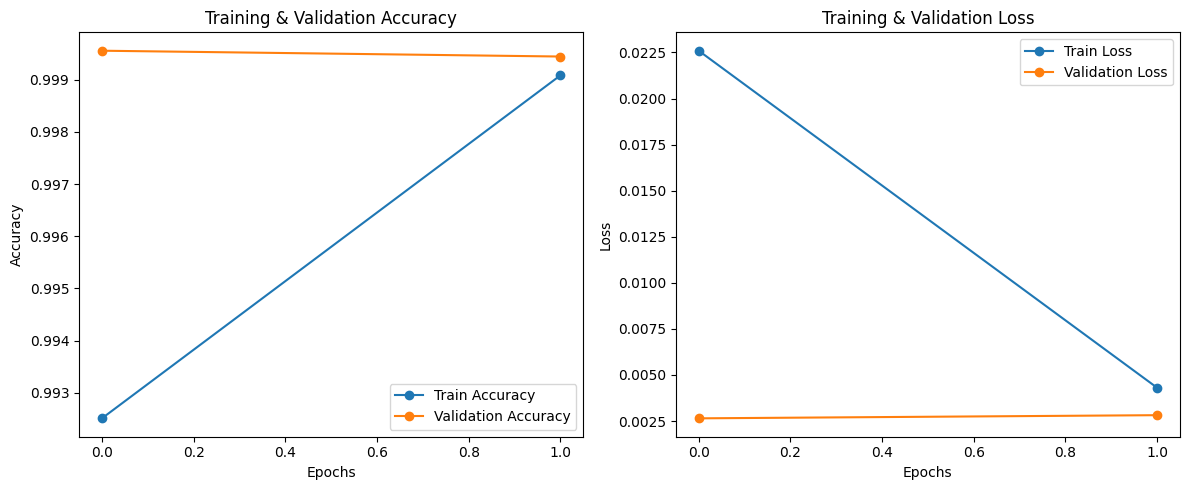

In [20]:
# Extract accuracy and loss from history
history_dict = history.history

# Plot Training & Validation Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict["accuracy"], label="Train Accuracy", marker='o')
plt.plot(history_dict["val_accuracy"], label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

# Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict["loss"], label="Train Loss", marker='o')
plt.plot(history_dict["val_loss"], label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
# Evaluate on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

281/281 ━━━━━━━━━━━━━━━━━━━━ 25s 90ms/step - accuracy: 0.9996 - loss: 0.0021
Test Accuracy: 99.94%


In [22]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to binary labels

print(classification_report(y_test, y_pred_classes, target_names=["Real", "Fake"]))

281/281 ━━━━━━━━━━━━━━━━━━━━ 25s 89ms/step
              precision    recall  f1-score   support

        Real       1.00      1.00      1.00      4696
        Fake       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



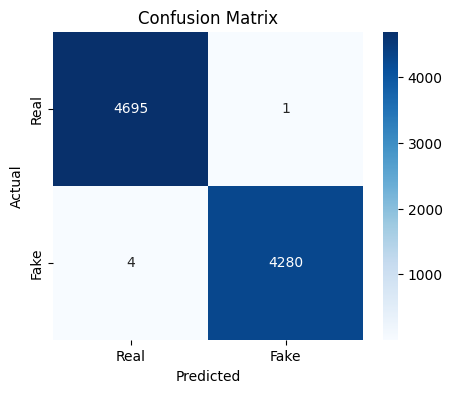

In [23]:
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [24]:
model.save("fake_news_detector.h5")  # Saves the trained model